# The Grange, Edinburgh, Scotland

In [1]:
import warnings
warnings.filterwarnings("ignore")

from libs.tools import *
from libs.graph_route import plot_graph_route

import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt

from network import Network
from network.algorithms import hierholzer
ox.settings.use_cache = True
ox.settings.log_console = True

In [2]:
CUSTOM_FILTER = (
    '["highway"]["area"!~"yes"]["highway"!~"bridleway|bus_guideway|bus_stop|construction|cycleway|elevator|footway|'
    'motorway|motorway_junction|motorway_link|escalator|proposed|construction|platform|raceway|rest_area|'
    'path|service"]["access"!~"customers|no|private"]["public_transport"!~"platform"]'
    '["fee"!~"yes"]["foot"!~"no"]["service"!~"drive-through|driveway|parking_aisle"]["toll"!~"yes"]'
)

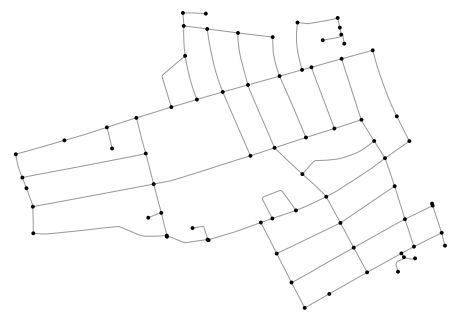

In [3]:
location = "The Grange, Edinburgh, Scotland"
org_graph = ox.graph_from_place(location, custom_filter=CUSTOM_FILTER)

# Simplifying the original directed multi-graph to undirected, so we can go both ways in one way streets
graph = ox.convert.to_undirected(org_graph)
fig, ax = ox.plot_graph(graph, node_zorder=2, node_color="k", bgcolor="w")

In [4]:
# Finds the odd degree nodes and minimal matching
odd_degree_nodes = get_odd_degree_nodes(graph)
pair_weights = get_shortest_distance_for_odd_degrees(graph, odd_degree_nodes)
matched_edges_with_weights = min_matching(pair_weights)

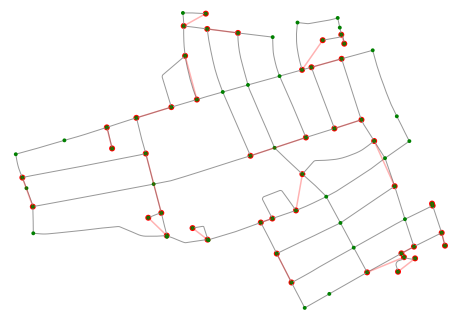

In [5]:
fig, ax = plt.subplots(figsize=(8, 8), facecolor='black', frameon=False)
for v, u, w in matched_edges_with_weights:
    x = graph.nodes[v]["x"], graph.nodes[u]["x"]
    y = graph.nodes[v]["y"], graph.nodes[u]["y"]
    ax.plot(x, y, c='red', alpha=0.3)
    ax.scatter(x, y, c='red', edgecolor="none")

fig, ax = ox.plot_graph(graph, node_zorder=2, node_color='g', bgcolor='k', ax=ax)

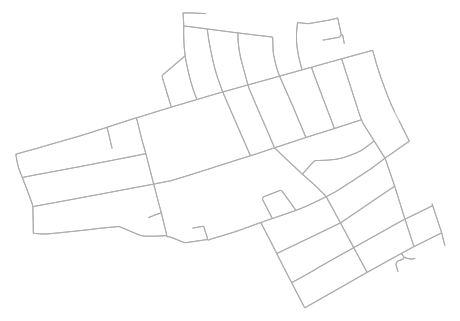

In [6]:
# List all edges of the extended graph including original edges and edges from minimal matching
single_edges = [(u, v) for u, v, k in graph.edges]
added_edges = get_shortest_paths(graph, matched_edges_with_weights)
edges = map_osmnx_edges2integers(graph, single_edges + added_edges)

# Finds the Eulerian path
network = Network(len(graph.nodes), edges, weighted=True)
eulerian_path = hierholzer(network)
converted_eulerian_path = convert_integer_path2osmnx_nodes(eulerian_path, graph.nodes())
double_edge_heap = get_double_edge_heap(org_graph)

# Finds the final path with edge IDs
final_path = convert_path(graph, converted_eulerian_path, double_edge_heap)

fig, ax = plot_graph_route(org_graph, final_path, route_linewidth=6, node_size=0, bgcolor="w", route_alpha=0.2, route_color="w")

In [ ]:
for i, e in enumerate(final_path, start=1):
    fig, ax = plot_graph_route(org_graph, final_path[:i], route_linewidth=6, node_size=0, bgcolor="w", route_alpha=0.2)
    ax.set_title(location)
    fig.savefig(f"/img_{i}.png", dpi=120, bbox_inches="tight")

![](docs/everystreet_grange.gif)